## EfficientNet Model

EfficientNet is a CNN that uses the concept of compound scaling to scale the image width, depth and resolution in a balanced manner to create a well performing yet efficient model given these three components.

Traditional CNN's choose one of the these dimmensions to scale on, while EfficientNet was designed to scale all three of these dimensions simultaneously using what's referred to as a compound coefficient. This was eloquently described in a medium article by saying, "Instead of randomly scaling up width, depth or resolution, compound scaling uniformly scales each dimension with a certain fixed set of scaling coefficients." (Source 2)

EfficientNet scales the width, depth and resolution using the compound coefficient to balance these three which allows the model to perform better and more efficiently. 

EfficientNet comes in different variants that vary in size, performance and number of parameters. EfficientNetB0 is considered to be the baseline model for EfficientNet and can scale all the way up to B7 which would be the largest and most complex model. EfficentNet Models:  B0, B1, B2, B3, B4, B5, B6, B7

##### Import Libraries

In [1]:
## Import the libraries
%reset -f
from __future__ import print_function

import math
import seaborn as sns
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import os
import glob
from tensorflow.data.experimental import load
import warnings
warnings.filterwarnings('ignore')

Note: There are some modifications in the paths and references to the imagenet dataset between this notebook and the ones published on Kaggle.

These notebooks will likely run very slowly due to the size of the datasets and because we were able to use GPU accelerators provided through Kaggle. 

Please restart the kernel and re-run pre-processing for each model as they may each have slightly different data augmentation/pre-processing and may intake different image dimmensions that need to be specified.

## EfficientNet B0 Baseline Model

We'll start by creating a baseline for our EfficientNet model by using the EfficientNetB0 baseline which will take an input of 224x224.

Features of our baseline:
EfficientNet models are often trained using the imagenet data which is why we pass in imagenet as the weights. The model will use transfer learning by using the pretrained imagenet weights.
EfficientNetB0 takes an input shape of 224x224x3 which is what we've standardized the data to.

We pass average as the pooling method in our baseline model which takes the average value of pixels in a region, lowers the number of parameters in our model and lowers the computation time. Since our data has humans, butterflies, machines and other features using an average pooling may help our model reduce noise in the images.

You can find the Kaggle notebook here: https://www.kaggle.com/code/emilylieske/efficientnetb0-baseline

Kaggle F1 score: 0.85063

#### Data Preparation and Necessary Pre-Processing

###### Function to decode and normalize the images and standardize to RGB

In [2]:
## Function to decode and normalize the images and standardize to RGB
image_size = [224,224]

def decode_image(image_data):
    """Function to decode the image from the .tfrec"""
    ## Converts the raw JPEG file bytes into a 3D tensor, channels=3  indicates RGB, create the shape (height, width, 3), the output is a uint tensor with values 0-255
    image = tf.image.decode_jpeg(image_data, channels=3)
    
    ## Resize all images to the image size specified above [512,512], using bilinear method to smooth the images for efficient processing
    image = tf.image.resize(image, image_size, method = "bilinear")
    
    ## Converts the uint to float32, then normalizes the inputs by dividing by the number of pixel values 255
    ## Commented out for EfficientNet model because it already has a rescaling layer in the model
    image = tf.cast(image, tf.float32) 
    
    ## Takes the image size defined above this function and reshapes it to be the image size [height, width, 3]
    image = tf.reshape(image, [*image_size,3])
    return image

###### Function to Load the Datasets

In [3]:
## Function to load the datasets
def load_dataset(filenames, labeled=True):
    """Load TFRecord dataset from filenames"""
    ## Creates a dataset that reads the files, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Creates a dataset of the raw binary .tfrec examples
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)

    ## dataset.map applies the read_labeled_tfrec function to each example, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Transforms the raw data to (image_tensor, label_int) pairs
    if labeled:
        dataset = dataset.map(read_labeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(read_unlabeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)       
    return dataset

###### Function to return an image, label pair for the training and validation sets

In [4]:
## Function to return an image, label pair for the training and validation sets
def read_labeled_tfrec(input_example):
    """Read and parse the labeled .tfrec"""
    ## Tells Tensorflow how to interpret the binary .tfrec data, "image" tells TF to expect binary jppeg bytes, "class" tells TF to expect integer labels (the flower labels)
    labeled_tfrec_format = { 
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    ## Parses the input_example using the format specified above
    ## Takes raw binary data (input_example) and uses the labeled_tfrec_format to return a dictionary {image bytes, flower label}
    input_example = tf.io.parse_single_example(input_example, labeled_tfrec_format)
    
    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])
    
    ## Process the label - input_example['class'] is the flower class ID
    label = tf.cast(input_example['class'], tf.int32)
    return image, label

###### Function to return an image without labels for the test set

In [5]:
## Function to return an image without labels for the test set
def read_unlabeled_tfrec(input_example):
    """Read and parse the unlabeled .tfrec"""
    unlabeled_tfrec_format = { 
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string)
    }    
    input_example = tf.io.parse_single_example(input_example, unlabeled_tfrec_format)
    
    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])
    
    ## Process the label - input_example['id'] is the image ID
    image_id = input_example['id']
    return image, image_id

###### Create the training, validation and test sets using only one of the provided image dimmensions

In [6]:
## Get filenames for 224x224 images only
folder = 'tfrecords-jpeg-224x224'
train_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/train/*.tfrec")
val_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/val/*.tfrec")
test_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/test/*.tfrec")

## Create train, validation and test data set
train_dataset = load_dataset(train_files, labeled=True)
validation_dataset = load_dataset(val_files, labeled=True)
test_dataset = load_dataset(test_files, labeled=False)

###### Shuffling the training and validation sets

In [7]:
## Shuffling the training and validation sets

## Sets random seed for reproducability
tf.random.set_seed(42)

## Set shuffle buffer to set how many are shuffled at once
shuffle_buffer = 500

## Shuffle the training set
train_dataset = train_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

## Shuffle the validation set
validation_dataset = validation_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

## No shuffling of test data as it's not needed

###### Set batch size and group data sets

In [8]:
## Set hyperparameters
## Sets the batch to 32 as the number of images to be processed at a time durin one forward/backward pass through the model, 32 is a default
## Larger batches take more memory and are more stable but if they batch is too large the model may generalize poorly
BATCH_SIZE = 32
## Tensorflow optimization that automatically determines the most optimal number of parallel processes
AUTO = tf.data.AUTOTUNE
## Sets the number of classes to the number of flower categories
NUM_CLASSES = 104

## Prepare the datasets for training by grouping a batch based on the size set above, and pre-fetches the next batch while the current batch is being processed
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTO)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTO)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTO)

###### Create and compile the model

In [9]:
def create_model():
    ## Load the pretrained EfficientNetB0 model
    ## Set include_top to false to remove the 1000 pre-set image net classification layers because we want to use the 104 flower classification labels
    ## Set weights to use pretrained ImageNet weights through ImageNet transfer learning
    ## Set the model to expect inputs with the shape (224, 224, 3)
    ## Sets the pooling to average to help reduce the number of parameters
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet', 
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    
    ## Freeze the pretrained weights - sets all layers in the base model not to be trainable
    ## This preserves the useful features learned by ImageNet, prevents changing the pre-trained imagenet weights, reduces training time and combats overfitting
    base_model.trainable = False
    
    ## Create the model
    ## Set .Dropout() to help regualrize the model and prevent overfitting, essentially say to leave out 20% of the neurons in training
    ## Pass NUM_CLASSES to specify the number of output to be 104 flower classes, activation softmax indicates all outputs should sum to 1, output represents probability it is that flower
    model = tf.keras.Sequential([
        base_model,
        ## Add dropout layer with .3 dropout
        tf.keras.layers.Dropout(0.3),
        ## Add dense layer
        tf.keras.layers.Dense(256, activation='relu'),
        ## Add another dropout layer with .2 dropout
        tf.keras.layers.Dropout(0.2),
        ## This is the output layer
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

## Create and compile the model
## Use the adam optimizer for efficiency and ability to adapt learning rates, sets the learning rate of the optimizer
## Loss is sparse (meaning not one-hot encoded but numerical 0-103, categorical_crossentropy is used for multiclass clasification
## Metrics track the accuracy
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

###### Set training parameters, epochs and callbacks

In [10]:
## Set training parameters
## Sets epochs
EPOCHS = 10

## EarlyStopping - Add callback to monitor the validation loss and stop training after 3 epochs if the loss stops improving and reverts the weights back to where the model was still improving and had converged, this helps prevent overfitting
##ReduceLROnPlateau - Add callback to monitor the validation loss and reduce the learning rate once performance starts to palteau, factor says multiply the learning rate by this value, patience say wait two epochs before reducing again, min_lr says don't go below this learning rate
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

## Train the model using the train_dataset, number of epochs, specifying the validation set as validation_dataset, and point to the callback defined above
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10


2025-07-28 12:32:54.057532: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144


    399/Unknown 166s 408ms/step - accuracy: 0.3247 - loss: 3.1304

2025-07-28 12:35:37.198878: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


399/399 ━━━━━━━━━━━━━━━━━━━━ 214s 529ms/step - accuracy: 0.3250 - loss: 3.1283 - val_accuracy: 0.7301 - val_loss: 1.1259 - learning_rate: 5.0000e-04
Epoch 2/10


2025-07-28 12:36:25.224658: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


399/399 ━━━━━━━━━━━━━━━━━━━━ 240s 601ms/step - accuracy: 0.6916 - loss: 1.2133 - val_accuracy: 0.8077 - val_loss: 0.7774 - learning_rate: 5.0000e-04
Epoch 3/10


2025-07-28 12:40:25.020886: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


399/399 ━━━━━━━━━━━━━━━━━━━━ 243s 610ms/step - accuracy: 0.7683 - loss: 0.8673 - val_accuracy: 0.8303 - val_loss: 0.6705 - learning_rate: 5.0000e-04
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 224s 562ms/step - accuracy: 0.8048 - loss: 0.7189 - val_accuracy: 0.8381 - val_loss: 0.6127 - learning_rate: 5.0000e-04
Epoch 5/10


2025-07-28 12:48:12.613299: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


399/399 ━━━━━━━━━━━━━━━━━━━━ 221s 554ms/step - accuracy: 0.8314 - loss: 0.6261 - val_accuracy: 0.8464 - val_loss: 0.5669 - learning_rate: 5.0000e-04
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 224s 563ms/step - accuracy: 0.8461 - loss: 0.5488 - val_accuracy: 0.8524 - val_loss: 0.5425 - learning_rate: 5.0000e-04
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 234s 586ms/step - accuracy: 0.8635 - loss: 0.4998 - val_accuracy: 0.8602 - val_loss: 0.5194 - learning_rate: 5.0000e-04
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 241s 604ms/step - accuracy: 0.8707 - loss: 0.4586 - val_accuracy: 0.8629 - val_loss: 0.5073 - learning_rate: 5.0000e-04
Epoch 9/10


2025-07-28 13:03:33.112646: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


399/399 ━━━━━━━━━━━━━━━━━━━━ 236s 591ms/step - accuracy: 0.8827 - loss: 0.4188 - val_accuracy: 0.8669 - val_loss: 0.4970 - learning_rate: 5.0000e-04
Epoch 10/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 258s 646ms/step - accuracy: 0.8808 - loss: 0.4029 - val_accuracy: 0.8650 - val_loss: 0.4980 - learning_rate: 5.0000e-04


###### Plot the training history

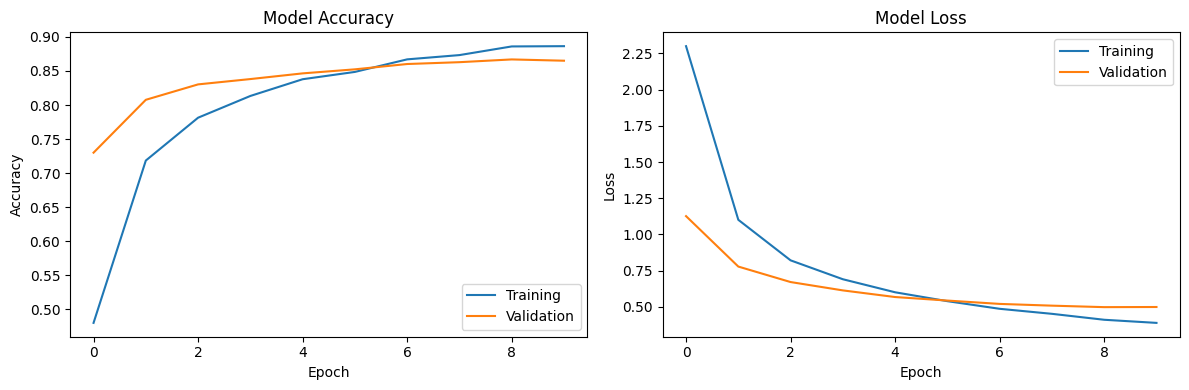

In [11]:
## Plot the training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ## Plot the accuracy
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ## Plot the loss
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## Show the training results
plot_training_history(history)

###### Function to assemble the models class predictions

In [ ]:
## Function to assemble the models class predictions
def get_predictions():
    image_ids = []
    predictions = []
    
    print("Getting predictions for test set...")
    batch_count = 0
    
    # Get predictions for test set (now properly batched)
    for batch_images, batch_image_names in test_dataset:
        batch_count += 1
        print(f"Processing batch {batch_count}, batch shape: {batch_images.shape}")
        
        # Get predictions for this batch
        pred = model.predict(batch_images, verbose=0)
        pred_labels = tf.argmax(pred, axis=1)
        
        # Convert tensor to numpy for easier handling
        batch_image_names = batch_image_names.numpy()
        pred_labels = pred_labels.numpy()
        
        # Extend our lists
        image_ids.extend([name.decode('utf-8') for name in batch_image_names])
        predictions.extend(pred_labels)
    
    print(f"Total predictions made: {len(predictions)}")
    return image_ids, predictions

###### Function to create the submission

In [ ]:
def create_submission():
    # Get predictions
    image_ids, predictions = get_predictions()
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'id': image_ids,
        'label': predictions
    })
    
    # Save submission file
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file created!")
    
# Create submission after training
create_submission()

## EfficientNet B0 - Data Balanced and Hyperparameter Tuned

To improve from our baseline model we augmented and created new data for all classes that had under 25 samples by applying a moderate random rotation, brightness and zoom along with a random flip across the horizontal (horizontal and vertical flips appeared to be problematic for the flower data since some flower images have an inherent vertical position if taken from a profile view.)

In order to help out model learn more robust features while preventing overfitting, we utilized a single dense layer with 256 neurons with two dropout layers of .3 and .2.

Additionally, since EfficientNet uses transfer learning from Imagenet, we froze only the bottom layers of the model to preserve some of the general pre-trained features from Imagenet.

These updates helped to improve the overall F1 score and this combination of hyperparameter tuning and specific data augmentation produced the highest results for the EfficientNet Model.

Other changes:
- Reduced the shuffle buffer from 500 to 200 for better handling of memory constraints
- Increased the batch size to 64 to speed up training and process in parallel while processing on Kaggle's GPU's

You can find the Kaggle notebook here: https://www.kaggle.com/code/emilylieske/efficientnetb0-data-balanced-parameter-tuned

Kaggle score: 0.90481

#### Data Preparation and Necessary Pre-Processing

###### Function to decode and normalize the images and standardize to RGB

In [2]:
## Function to decode and normalize the images and standardize to RGB
image_size = [224,224]

def decode_image(image_data):
    """Function to decode the image from the .tfrec"""
    ## Converts the raw JPEG file bytes into a 3D tensor, channels=3  indicates RGB, create the shape (height, width, 3), the output is a uint tensor with values 0-255
    image = tf.image.decode_jpeg(image_data, channels=3)
    
    ## Resize all images to the image size specified above [224,224], using bilinear method to smooth the images for efficient processing
    image = tf.image.resize(image, image_size, method = "bilinear")
    
    ## Converts the uint to float32, no further standardization for EfficientNet model because it already has a rescaling layer in the model
    image = tf.cast(image, tf.float32) 
    
    ## Takes the image size defined above this function and reshapes it to be the image size [height, width, 3]
    image = tf.reshape(image, [*image_size,3])
    return image

###### Function to Load the Datasets

In [3]:
## Function to load the datasets
def load_dataset(filenames, labeled=True):
    """Load TFRecord dataset from filenames"""
    ## Creates a dataset that reads the files, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Creates a dataset of the raw binary .tfrec examples
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)

    ## dataset.map applies the read_labeled_tfrec function to each example, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Transforms the raw data to (image_tensor, label_int) pairs
    if labeled:
        dataset = dataset.map(read_labeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(read_unlabeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)       
    return dataset

###### Function to return an image, label pair for the training and validation sets

In [4]:
## Function to return an image, label pair for the training and validation sets
def read_labeled_tfrec(input_example):
    """Read and parse the labeled .tfrec"""
    ## Tells Tensorflow how to interpret the binary .tfrec data, "image" tells TF to expect binary jppeg bytes, "class" tells TF to expect integer labels (the flower labels)
    labeled_tfrec_format = { 
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    ## Parses the input_example using the format specified above
    ## Takes raw binary data (input_example) and uses the labeled_tfrec_format to return a dictionary {image bytes, flower label}
    input_example = tf.io.parse_single_example(input_example, labeled_tfrec_format)
    
    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])
    
    ## Process the label - input_example['class'] is the flower class ID
    label = tf.cast(input_example['class'], tf.int32)
    return image, label

###### Function to return an image without labels for the test set

In [5]:
def read_unlabeled_tfrec(input_example):
    """Read and parse the unlabeled .tfrec"""
    unlabeled_tfrec_format = { 
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string)
    }    
    input_example = tf.io.parse_single_example(input_example, unlabeled_tfrec_format)
    
    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])
    
    ## Process the label - input_example['id'] is the image ID
    image_id = input_example['id']
    return image, image_id

###### Create the training, validation and test sets using only one of the provided image dimmensions

In [6]:
## Get filenames for 224x224 images only
folder = 'tfrecords-jpeg-224x224'
train_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/train/*.tfrec")
val_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/val/*.tfrec")
test_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/test/*.tfrec")

## Create train, validation and test data set
train_dataset = load_dataset(train_files, labeled=True)
validation_dataset = load_dataset(val_files, labeled=True)
test_dataset = load_dataset(test_files, labeled=False)

###### Function to create augmented data for the minority represented classes

In [7]:
## Balance the dataset by creating augmented data only for the classes thathave less than the specified number of samples. 
def quick_balance(dataset, min_samples=25):
    ## Count the classes
    class_counts = {}
    for _, label in dataset:
        lbl = int(label.numpy())
        class_counts[lbl] = class_counts.get(lbl, 0) + 1
    
    ## Find minority classes
    minority_classes = [cls for cls, count in class_counts.items() if count < min_samples]
    print(f"Boosting {len(minority_classes)} minority classes")
    
    
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.RandomZoom(0.1)
    ])

    minority_data = dataset.filter(lambda img, lbl: tf.reduce_any(tf.equal(lbl, minority_classes)))
    boosted_minorities = minority_data.map(lambda img, lbl: (augmentation(img, training=True), lbl)).repeat(3)

    ## Concatenates the training data only with the minority classes augmented data
    return dataset.concatenate(boosted_minorities).shuffle(10000)
    
## Apply balancing to training data only
train_dataset = quick_balance(train_dataset, min_samples=25)
## Keep validation dataset unchanged

2025-07-28 13:24:46.403871: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-07-28 13:24:48.250524: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Boosting 16 minority classes


###### Shuffling the training and validation sets

In [8]:
## Shuffling the training and validation sets

## Sets random seed for reproducability
tf.random.set_seed(42)

## Set shuffle buffer to set how many are shuffled at once
shuffle_buffer = 500

## Shuffle the training set
train_dataset = train_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

## Shuffle the validation set
validation_dataset = validation_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

## No shuffling of test data as it's not needed

###### Set batch size and group data sets

In [9]:
## Set hyperparameters
## Sets the batch to 32 as the number of images to be processed at a time durin one forward/backward pass through the model, 32 is a default
## Larger batches take more memory and are more stable but if they batch is too large the model may generalize poorly
BATCH_SIZE = 32
## Tensorflow optimization that automatically determines the most optimal number of parallel processes
AUTO = tf.data.AUTOTUNE
## Sets the number of classes to the number of flower categories
NUM_CLASSES = 104

## Prepare the datasets for training by grouping a batch based on the size set above, and pre-fetches the next batch while the current batch is being processed
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTO)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTO)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTO)

###### Create and compile the model

In [10]:
def create_b0_model():
    ## Load the pretrained EfficientNetB0 model
    ## Set include_top to false to remove the 1000 pre-set image net classification layers because we want to use the 104 flower classification labels
    ## Set weights to use pretrained ImageNet weights through ImageNet transfer learning
    ## Set the model to expect inputs with the shape (224, 224, 3)
    ## Sets the pooling to average to help reduce the number of parameters
    b0_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet', 
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    
    ## Unfreeze the top layers for hyperparameter tuning
    b0_model.trainable = True

    ## Freeze only the bottom layers of the model
    tuned = int(len(b0_model.layers) *.8)
    for layer in b0_model.layers[:tuned]:
        layer.trainable = False
    
    ## Create the model
    ## Set .Dropout() to help regualrize the model and prevent overfitting, essentially say to leave out 20% of the neurons in training
    ## Pass NUM_CLASSES to specify the number of output to be 104 flower classes, activation softmax indicates all outputs should sum to 1, output represents probability it is that flower
    model = tf.keras.Sequential([
        b0_model,
        ## Add dropout layer with .3 dropout
        tf.keras.layers.Dropout(0.3),
        ## Add dense layer
        tf.keras.layers.Dense(256, activation='relu'),
        ## Add another dropout layer with .2 dropout
        tf.keras.layers.Dropout(0.2),
        ## This is the output layer
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

## Create and compile the model
## Use the adam optimizer for efficiency and ability to adapt learning rates, sets the learning rate of the optimizer
## Loss is sparse (meaning not one-hot encoded but numerical 0-103, categorical_crossentropy is used for multiclass clasification
## Metrics track the accuracy
model = create_b0_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

###### Set training parameters, epochs and callbacks

In [11]:
## Set training parameters
## Sets epochs
EPOCHS = 25

## EarlyStopping - Add callback to monitor the validation loss and stop training after 3 epochs if the loss stops improving and reverts the weights back to where the model was still improving and had converged, this helps prevent overfitting
##ReduceLROnPlateau - Add callback to monitor the validation loss and reduce the learning rate once performance starts to palteau, factor says multiply the learning rate by this value, patience say wait two epochs before reducing again, min_lr says don't go below this learning rate
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-4
    )
]

## Train the model using the train_dataset, number of epochs, specifying the validation set as validation_dataset, and point to the callback defined above
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/25
    430/Unknown 247s 554ms/step - accuracy: 0.4432 - loss: 2.5641

2025-07-28 13:34:30.650603: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


430/430 ━━━━━━━━━━━━━━━━━━━━ 294s 664ms/step - accuracy: 0.4436 - loss: 2.5618 - val_accuracy: 0.8518 - val_loss: 0.5575 - learning_rate: 5.0000e-04
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.8627 - loss: 0.5055

2025-07-28 13:39:36.581814: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


430/430 ━━━━━━━━━━━━━━━━━━━━ 308s 708ms/step - accuracy: 0.8627 - loss: 0.5055 - val_accuracy: 0.8825 - val_loss: 0.4562 - learning_rate: 5.0000e-04
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 307s 705ms/step - accuracy: 0.9148 - loss: 0.3055 - val_accuracy: 0.8933 - val_loss: 0.4102 - learning_rate: 5.0000e-04
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.9414 - loss: 0.2045

2025-07-28 13:49:51.997213: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


430/430 ━━━━━━━━━━━━━━━━━━━━ 315s 726ms/step - accuracy: 0.9414 - loss: 0.2045 - val_accuracy: 0.8952 - val_loss: 0.4389 - learning_rate: 5.0000e-04
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 310s 713ms/step - accuracy: 0.9566 - loss: 0.1565 - val_accuracy: 0.8947 - val_loss: 0.4567 - learning_rate: 5.0000e-04
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 301s 692ms/step - accuracy: 0.9730 - loss: 0.0897 - val_accuracy: 0.9151 - val_loss: 0.3667 - learning_rate: 1.0000e-04
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 328s 756ms/step - accuracy: 0.9821 - loss: 0.0623 - val_accuracy: 0.9208 - val_loss: 0.3688 - learning_rate: 1.0000e-04
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 646ms/step - accuracy: 0.9861 - loss: 0.0524

2025-07-28 14:11:07.646110: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


430/430 ━━━━━━━━━━━━━━━━━━━━ 330s 759ms/step - accuracy: 0.9861 - loss: 0.0524 - val_accuracy: 0.9195 - val_loss: 0.3687 - learning_rate: 1.0000e-04
Epoch 9/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 367s 845ms/step - accuracy: 0.9889 - loss: 0.0390 - val_accuracy: 0.9200 - val_loss: 0.3676 - learning_rate: 1.0000e-04


In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 104)            │        26,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,724,157 (37.09 MB)

 Trainable params: 2,659,960 (10.15 MB)

 Non-trainable params: 1,744,275 (6.65 MB)

 Optimizer params: 5,319,922 (20.29 MB)

###### Plot the training history

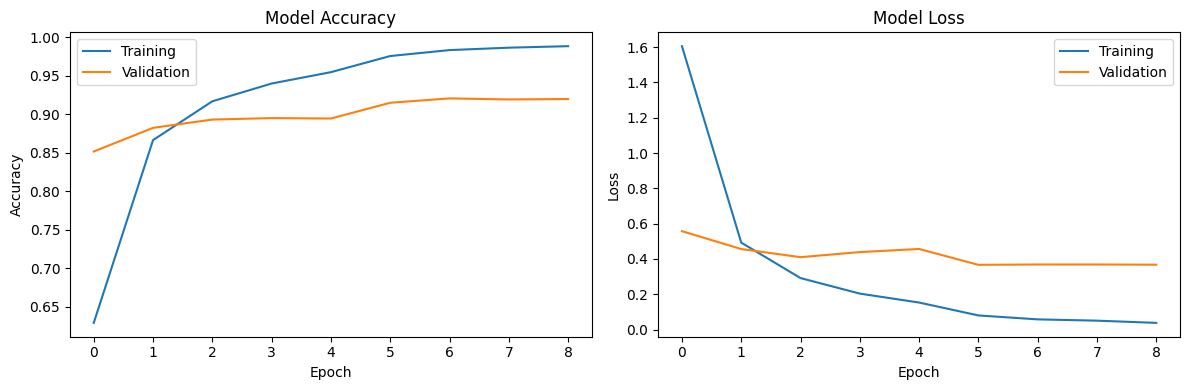

In [13]:
## Plot the training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ## Plot the accuracy
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ## Plot the loss
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## Show the training results
plot_training_history(history)

###### Function to assemble the models class predictions

In [ ]:
## Function to assemble the models class predictions
def get_predictions():
    image_ids = []
    predictions = []
    
    print("Getting predictions for test set...")
    batch_count = 0
    
    # Get predictions for test set (now properly batched)
    for batch_images, batch_image_names in test_dataset:
        batch_count += 1
        print(f"Processing batch {batch_count}, batch shape: {batch_images.shape}")
        
        # Get predictions for this batch
        pred = model.predict(batch_images, verbose=0)
        pred_labels = tf.argmax(pred, axis=1)
        
        # Convert tensor to numpy for easier handling
        batch_image_names = batch_image_names.numpy()
        pred_labels = pred_labels.numpy()
        
        # Extend our lists
        image_ids.extend([name.decode('utf-8') for name in batch_image_names])
        predictions.extend(pred_labels)
    
    print(f"Total predictions made: {len(predictions)}")
    return image_ids, predictions

###### Function to create the submission

In [ ]:
def create_submission():
    # Get predictions
    image_ids, predictions = get_predictions()
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'id': image_ids,
        'label': predictions
    })
    
    # Save submission file
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file created!")
    
# Create submission after training
create_submission()

## EfficientNet B1 - Data Balanced and Hyperparameter Tuned

To further explore improvements to the baseline model we explored using the EfficientNet B1 model which takes a larger image dimmension as it's input and is also a significantly larger model taking in more parameters.

In order to help out model learn more robust features while preventing overfitting, we utilized a single dense layer with 256 neurons with two dropout layers of .3 and .2.

We applied some more extensive data augmentation by slightly increasing the random rotation, brightness and zoom whil also adding contrast into out data augmentation. 

The layers and dropout are the same as the baseline, but we've frozen 10% of the base layers for transfer learning with imagenet and we've increased the learning rate to 2e-3 for faster convergence. 

Other updates: 
- Increased shuffle buffer from 200 to 250
- Increased batch size from 32 to 48
- - Updated callbacks to monitor accuracy and not loss

You can find the Kaggle notebook here: https://www.kaggle.com/code/emilylieske/efficientnetb1-hyperparameter-tuned

Kaggle score: 0.90204

#### Data Preparation and Necessary Pre-Processing

###### Function to decode and normalize the images and standardize to RGB

In [2]:
## Function to decode and normalize the images and standardize to RGB
image_size = [240,240]

def decode_image(image_data):
    """Function to decode the image from the .tfrec"""
    ## Converts the raw JPEG file bytes into a 3D tensor, channels=3  indicates RGB, create the shape (height, width, 3), the output is a uint tensor with values 0-255
    image = tf.image.decode_jpeg(image_data, channels=3)
    
    ## Resize all images to the image size specified above [512,512], using bilinear method to smooth the images for efficient processing
    image = tf.image.resize(image, image_size, method = "bilinear")
    
    ## Converts the uint to float32, then normalizes the inputs by dividing by the number of pixel values 255
    ## Commented out for EfficientNet model because it already has a rescaling layer in the model
    image = tf.cast(image, tf.float32) 
    # / 255.0
    
    ## Takes the image size defined above this function and reshapes it to be the image size [height, width, 3]
    image = tf.reshape(image, [*image_size,3])
    return image

###### Function to Load the Datasets

In [3]:
## Function to load the datasets
def load_dataset(filenames, labeled=True):
    """Load TFRecord dataset from filenames"""
    ## Creates a dataset that reads the files, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Creates a dataset of the raw binary .tfrec examples
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)

    ## dataset.map applies the read_labeled_tfrec function to each example, AUTOTUNE processes them simultneously and TF optimizes the number of readers
    ## Transforms the raw data to (image_tensor, label_int) pairs
    if labeled:
        dataset = dataset.map(read_labeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(read_unlabeled_tfrec, num_parallel_calls=tf.data.AUTOTUNE)       
    return dataset

###### Function to return an image, label pair for the training and validation sets

In [4]:
## Function to return an image, label pair for the training and validation sets
def read_labeled_tfrec(input_example):
    """Read and parse the labeled .tfrec"""
    ## Tells Tensorflow how to interpret the binary .tfrec data, "image" tells TF to expect binary jppeg bytes, "class" tells TF to expect integer labels (the flower labels)
    labeled_tfrec_format = { 
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    ## Parses the input_example using the format specified above
    ## Takes raw binary data (input_example) and uses the labeled_tfrec_format to return a dictionary {image bytes, flower label}
    input_example = tf.io.parse_single_example(input_example, labeled_tfrec_format)
    
    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])
    
    ## Process the label - input_example['class'] is the flower class ID
    label = tf.cast(input_example['class'], tf.int32)
    return image, label

###### Function to return an image without labels for the test set

In [5]:
def read_unlabeled_tfrec(input_example):
    """Read and parse the unlabeled .tfrec"""
    unlabeled_tfrec_format = { 
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string)
    }    
    input_example = tf.io.parse_single_example(input_example, unlabeled_tfrec_format)
    
    ## Process the image - Takes the JPEG bytes from the example image, and normalizes them to a [512,512,3] tensor using the decode_image function
    image = decode_image(input_example["image"])
    
    ## Process the label - input_example['id'] is the image ID
    image_id = input_example['id']
    return image, image_id

###### Create the training, validation and test sets using only one of the provided image dimmensions

In [6]:
## Get filenames for 224x224 images only
folder = 'tfrecords-jpeg-224x224'
train_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/train/*.tfrec")
val_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/val/*.tfrec")
test_files = tf.io.gfile.glob(f"./tpu-getting-started/{folder}/test/*.tfrec")

## Create train, validation and test data set
train_dataset = load_dataset(train_files, labeled=True)
validation_dataset = load_dataset(val_files, labeled=True)
test_dataset = load_dataset(test_files, labeled=False)

###### Function to create augmented data for the minority represented classes

In [7]:
## Balance the dataset by creating augmented data only for the classes that 
def quick_balance(dataset, min_samples=50):
    ## Count the classes
    class_counts = {}
    for _, label in dataset:
        lbl = int(label.numpy())
        class_counts[lbl] = class_counts.get(lbl, 0) + 1
    
    ## Find minority classes
    minority_classes = [cls for cls, count in class_counts.items() if count < min_samples]
    print(f"Boosting {len(minority_classes)} minority classes")
    
    
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.15),
        tf.keras.layers.RandomBrightness(0.15),
        tf.keras.layers.RandomContrast(0.1),
        tf.keras.layers.RandomZoom(0.15)
    ])

    minority_data = dataset.filter(lambda img, lbl: tf.reduce_any(tf.equal(lbl, minority_classes)))
    boosted_minorities = minority_data.map(lambda img, lbl: (augmentation(img, training=True), lbl)).repeat(4)

    ## Concatenates the training data only with the minority classes augmented data
    return dataset.concatenate(boosted_minorities)

## Apply balancing to training data only
train_dataset = quick_balance(train_dataset, min_samples=50)
## Keep validation dataset unchanged

2025-07-28 14:27:39.148020: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-07-28 14:27:41.759548: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Boosting 36 minority classes


###### Shuffling the training and validation sets

In [8]:
## Shuffling the training and validation sets

## Sets random seed for reproducability
tf.random.set_seed(42)

## Set shuffle buffer to set how many are shuffled at once
shuffle_buffer = 250

## Shuffle the training set
train_dataset = train_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

## Shuffle the validation set
validation_dataset = validation_dataset.shuffle(shuffle_buffer, seed=42, reshuffle_each_iteration=False)

## No shuffling of test data as it's not needed

###### Set batch size and group data sets

In [9]:
## Set hyperparameters
## Sets the batch to 48 as the number of images to be processed at a time durin one forward/backward pass through the model, 32 is a default
## Larger batches take more memory and are more stable but if they batch is too large the model may generalize poorly
BATCH_SIZE = 48
## Tensorflow optimization that automatically determines the most optimal number of parallel processes
AUTO = tf.data.AUTOTUNE
## Sets the number of classes to the number of flower categories
NUM_CLASSES = 104

## Prepare the datasets for training by grouping a batch based on the size set above, and pre-fetches the next batch while the current batch is being processed
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTO)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTO)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTO)

###### Create and compile the model

In [10]:
def create_b1_model():
    ## Load the pretrained EfficientNetB1 model
    ## Set include_top to false to remove the 1000 pre-set image net classification layers because we want to use the 104 flower classification labels
    ## Set weights to use pretrained ImageNet weights through ImageNet transfer learning
    ## Set the model to expect inputs with the shape (240, 240, 3) - EfficientNetB4 input size
    ## Sets the pooling to average to help reduce the number of parameters
    b1_model = tf.keras.applications.EfficientNetB1(
        include_top=False,
        weights='imagenet', 
        input_shape=(240, 240, 3),
        pooling='avg'
    )
    
    ## Unfreeze the top layers for hyperparameter tuning
    b1_model.trainable = True

    ## Freeze only the bottom layers of the model
    tuned = int(len(b1_model.layers) *.9)
    for layer in b1_model.layers[:tuned]:
        layer.trainable = False
    
    ## Create the model with slightly higher dropout for the larger model
    b1_model = tf.keras.Sequential([
        b1_model,
        ## Add another dropout layer with .3 dropout
        tf.keras.layers.Dropout(0.3),
        ## Add a dense layer with 256 neurons
        tf.keras.layers.Dense(256, activation='relu'),
        ## Add another dropout layer with .2 dropout
        tf.keras.layers.Dropout(0.2),
        ## This is the output layer
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return b1_model

## Create and compile the model
## Use the adam optimizer for efficiency and ability to adapt learning rates, sets the learning rate of the optimizer
## Loss is sparse (meaning not one-hot encoded but numerical 0-103, categorical_crossentropy is used for multiclass clasification
## Metrics track the accuracy
model = create_b1_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

###### Set training parameters, epochs and callbacks

In [11]:
## Set training parameters
## Sets epochs
EPOCHS = 20

## EarlyStopping - Add callback to monitor the validation accuracy and stop training after 3 epochs if the accuracy stops improving and reverts the weights back to where the model was still improving and had converged, this helps prevent overfitting
##ReduceLROnPlateau - Add callback to monitor the validation accuracy and reduce the learning rate once performance starts to palteau, factor says multiply the learning rate by this value, patience say wait two epochs before reducing again, min_lr says don't go below this learning rate
## Updated monitor from val_loss to val_accuracy
## Setting mode='max' to maximize accuracy
## Increased the factor for reducing the learning rate
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        mode='max'
    )
]

## Train the model using the train_dataset, number of epochs, specifying the validation set as validation_dataset, and point to the callback defined above
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/20
    349/Unknown 516s 1s/step - accuracy: 0.5540 - loss: 1.9518

2025-07-28 14:37:33.854225: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


349/349 ━━━━━━━━━━━━━━━━━━━━ 616s 2s/step - accuracy: 0.5545 - loss: 1.9494 - val_accuracy: 0.2629 - val_loss: 4.9368 - learning_rate: 0.0020
Epoch 2/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7848 - loss: 0.8512

2025-07-28 14:49:02.427218: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


349/349 ━━━━━━━━━━━━━━━━━━━━ 678s 2s/step - accuracy: 0.7850 - loss: 0.8502 - val_accuracy: 0.5342 - val_loss: 2.3510 - learning_rate: 0.0020
Epoch 3/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 630s 2s/step - accuracy: 0.8605 - loss: 0.4762 - val_accuracy: 0.6452 - val_loss: 1.8084 - learning_rate: 0.0020
Epoch 4/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8890 - loss: 0.3695

2025-07-28 15:10:15.358594: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


349/349 ━━━━━━━━━━━━━━━━━━━━ 634s 2s/step - accuracy: 0.8891 - loss: 0.3693 - val_accuracy: 0.6382 - val_loss: 1.9270 - learning_rate: 0.0020
Epoch 5/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.9073 - loss: 0.3146 - val_accuracy: 0.6659 - val_loss: 1.6725 - learning_rate: 0.0020
Epoch 6/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 570s 2s/step - accuracy: 0.9233 - loss: 0.2501 - val_accuracy: 0.7260 - val_loss: 1.6061 - learning_rate: 0.0020
Epoch 7/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 611s 2s/step - accuracy: 0.9383 - loss: 0.2027 - val_accuracy: 0.7400 - val_loss: 1.7971 - learning_rate: 0.0020
Epoch 8/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9388 - loss: 0.2270

2025-07-28 15:49:16.195928: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


349/349 ━━━━━━━━━━━━━━━━━━━━ 610s 2s/step - accuracy: 0.9388 - loss: 0.2268 - val_accuracy: 0.7629 - val_loss: 1.4419 - learning_rate: 0.0020
Epoch 9/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.9468 - loss: 0.1873 - val_accuracy: 0.6999 - val_loss: 1.9081 - learning_rate: 0.0020
Epoch 10/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.9443 - loss: 0.1934 - val_accuracy: 0.7729 - val_loss: 1.4683 - learning_rate: 0.0020
Epoch 11/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 793s 2s/step - accuracy: 0.9568 - loss: 0.1527 - val_accuracy: 0.7643 - val_loss: 1.5537 - learning_rate: 0.0020
Epoch 12/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.9595 - loss: 0.1427 - val_accuracy: 0.7567 - val_loss: 1.5806 - learning_rate: 0.0020
Epoch 13/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 612s 2s/step - accuracy: 0.9631 - loss: 0.1190 - val_accuracy: 0.8860 - val_loss: 0.7104 - learning_rate: 0.0010
Epoch 14/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 573s 2s/step - accuracy: 0.9871 - loss: 0.0421 -

2025-07-28 17:11:23.319880: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


349/349 ━━━━━━━━━━━━━━━━━━━━ 592s 2s/step - accuracy: 0.9911 - loss: 0.0243 - val_accuracy: 0.8947 - val_loss: 0.7133 - learning_rate: 0.0010
Epoch 17/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 602s 2s/step - accuracy: 0.9935 - loss: 0.0216 - val_accuracy: 0.9062 - val_loss: 0.6693 - learning_rate: 5.0000e-04
Epoch 18/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.9968 - loss: 0.0122 - val_accuracy: 0.9049 - val_loss: 0.6992 - learning_rate: 5.0000e-04
Epoch 19/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.9969 - loss: 0.0105 - val_accuracy: 0.9103 - val_loss: 0.6767 - learning_rate: 5.0000e-04
Epoch 20/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 689s 2s/step - accuracy: 0.9979 - loss: 0.0075 - val_accuracy: 0.9108 - val_loss: 0.6672 - learning_rate: 5.0000e-04


###### Plot the training history

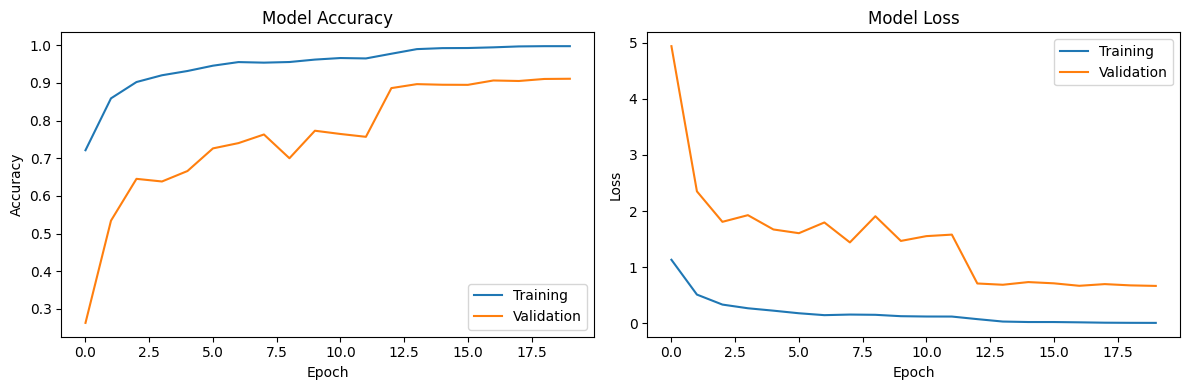

In [12]:
## Plot the training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ## Plot the accuracy
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ## Plot the loss
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## Show the training results
plot_training_history(history)

###### Function to assemble the models class predictions

In [ ]:
## Function to assemble the models class predictions
def get_predictions():
    image_ids = []
    predictions = []
    
    print("Getting predictions for test set...")
    batch_count = 0
    
    # Get predictions for test set (now properly batched)
    for batch_images, batch_image_names in test_dataset:
        batch_count += 1
        print(f"Processing batch {batch_count}, batch shape: {batch_images.shape}")
        
        # Get predictions for this batch
        pred = model.predict(batch_images, verbose=0)
        pred_labels = tf.argmax(pred, axis=1)
        
        # Convert tensor to numpy for easier handling
        batch_image_names = batch_image_names.numpy()
        pred_labels = pred_labels.numpy()
        
        # Extend our lists
        image_ids.extend([name.decode('utf-8') for name in batch_image_names])
        predictions.extend(pred_labels)
    
    print(f"Total predictions made: {len(predictions)}")
    return image_ids, predictions

###### Function to create the submission

In [ ]:
def create_submission():
    # Get predictions
    image_ids, predictions = get_predictions()
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'id': image_ids,
        'label': predictions
    })
    
    # Save submission file
    submission_df.to_csv('submission.csv', index=False)
    print("Submission file created!")
    
# Create submission after training
create_submission()